PURDUE SUBTERRANEAN RESEARCH

IMPORT DEPENDENCIES

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

READ IMAGE AND GRAYSCALE

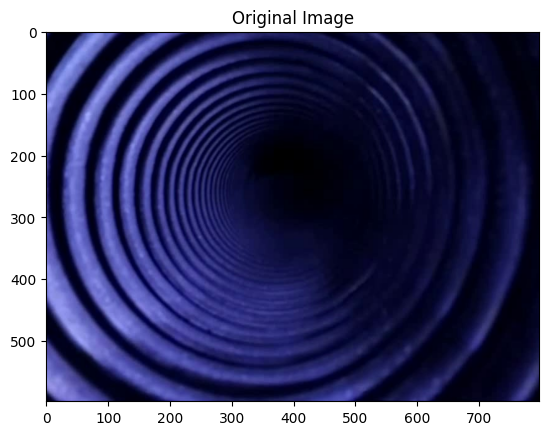

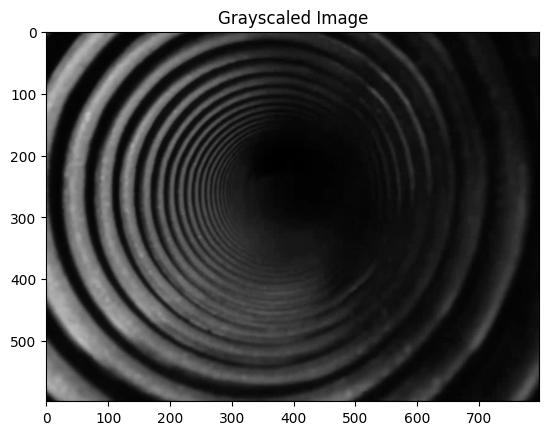

In [23]:
pipe_pic = cv2.imread("Pipe_Detection_Model/Images/frame13.jpg")
pipe_pic = cv2.cvtColor(pipe_pic, cv2.COLOR_BGR2RGB)
plt.imshow(pipe_pic)
plt.title('Original Image')
plt.show()

gray_pipe_pic = cv2.cvtColor(pipe_pic, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_pipe_pic, cmap="gray", vmin=0, vmax=255)
plt.title('Grayscaled Image')
plt.show()

INCREASE BRIGHTNESS AND CONTRAST + GAUSSIAN BLUR

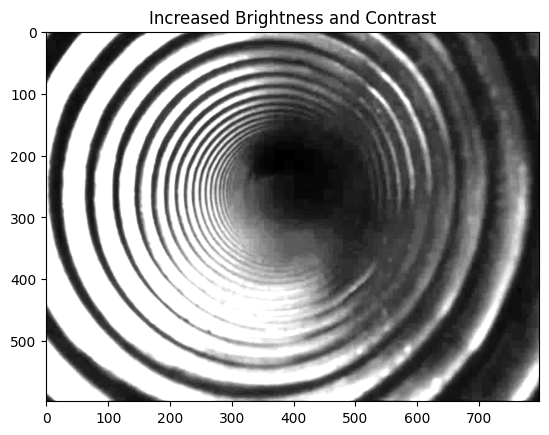

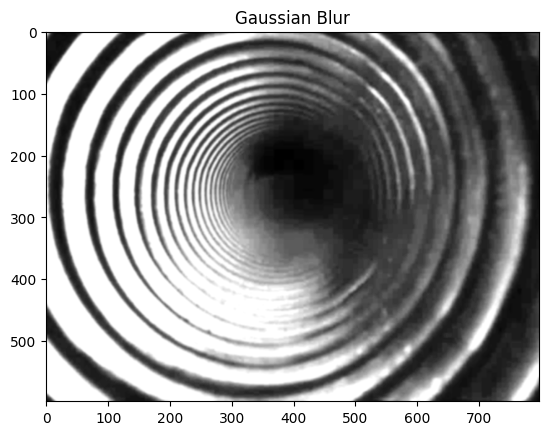

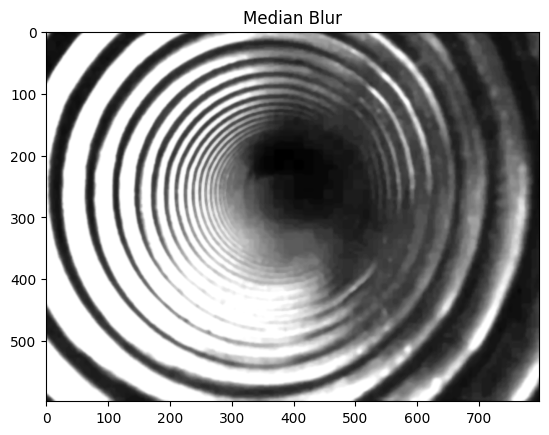

In [24]:
edited_gray_pipe_pic = cv2.convertScaleAbs(gray_pipe_pic, 5, 4)
plt.imshow(edited_gray_pipe_pic, cmap="gray")
plt.title('Increased Brightness and Contrast')
plt.show()

edited_gray_pipe_pic = cv2.GaussianBlur(edited_gray_pipe_pic, (5,5), 1)
plt.imshow(edited_gray_pipe_pic, cmap="gray")
plt.title('Gaussian Blur')
plt.show()

median_blur = cv2.medianBlur(edited_gray_pipe_pic, 5)
plt.imshow(median_blur, cmap="gray")
plt.title('Median Blur')
plt.show()

HISTOGRAM EQUALIZATION

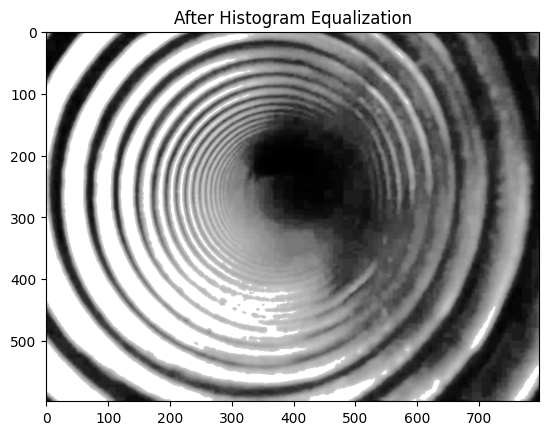

In [25]:
eq_hist = cv2.equalizeHist(edited_gray_pipe_pic)
plt.imshow(eq_hist, cmap="gray")
plt.title('After Histogram Equalization')
plt.show()

CONTRAST LIMITED ADAPTIVE HISTOGRAM EQUALIZATION

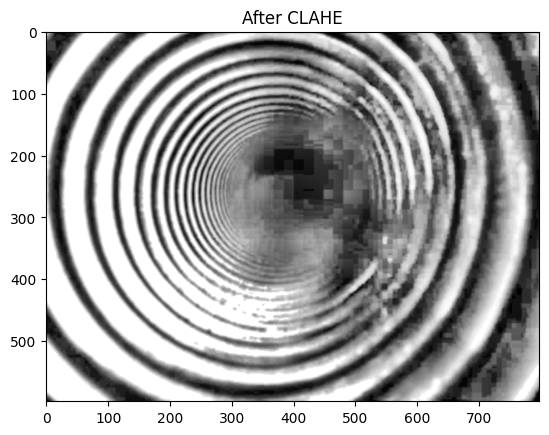

In [26]:
clahe = cv2.createCLAHE(clipLimit=20)
cl = clahe.apply(edited_gray_pipe_pic)
plt.imshow(cl, cmap="gray")
plt.title('After CLAHE')
plt.show()

ADAPTIVE THRESHOLDING

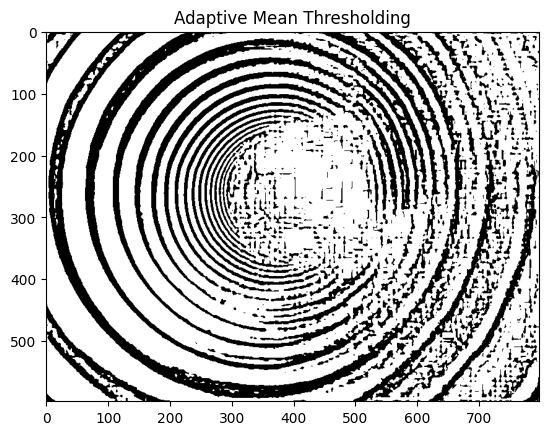

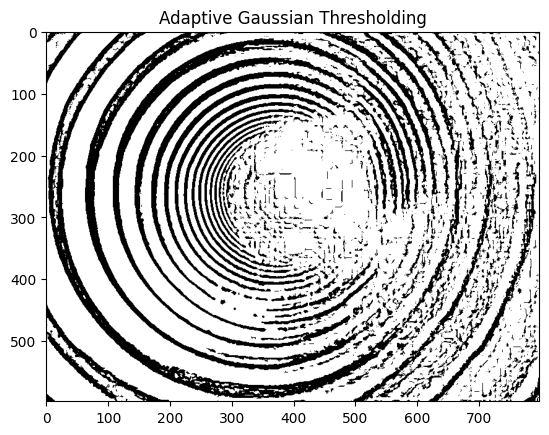

In [27]:
mean_ad = cv2.adaptiveThreshold(edited_gray_pipe_pic, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 3)
plt.imshow(mean_ad, cmap='gray')
plt.title('Adaptive Mean Thresholding')
plt.show()

gaussian_ad = cv2.adaptiveThreshold(median_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
plt.imshow(gaussian_ad, cmap='gray')
plt.title('Adaptive Gaussian Thresholding')
plt.show()

MORPHOLOGY

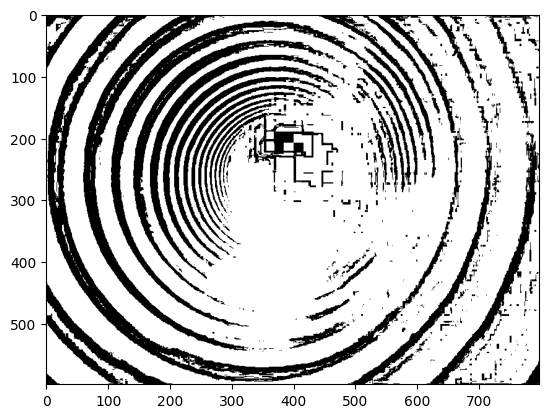

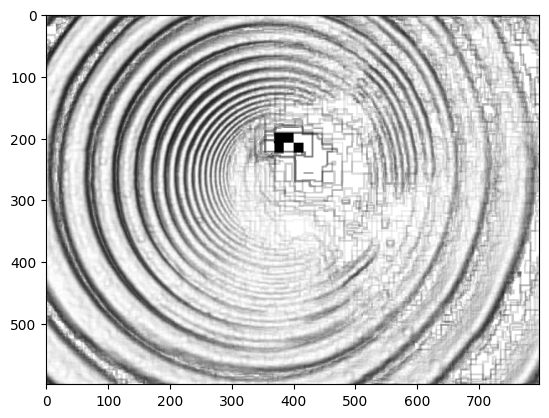

In [28]:


se = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
bg = cv2.morphologyEx(gray_pipe_pic, cv2.MORPH_DILATE, se)

out = cv2.divide(gray_pipe_pic, bg, scale=255)
morph = cv2.threshold(out, 0, 255, cv2.THRESH_OTSU)[1]

plt.imshow(morph, cmap='gray')
plt.show()

plt.imshow(out, cmap='gray')
plt.show()

HOUGHCIRCLES IMPLEMENTATION + RESULTS

[340 256 336]
[362 262 219]
[346 268 270]
[354 258 247]
[356 266 237]
[370 268 218]
[356 250 296]
[346 258 240]
[364 250 260]
[362 280 268]
[370 254 163]
[498 336 234]
[498 304 254]
[528 252 237]
[374 274 200]
[512 296 243]
[526 264 255]
[532 274 251]
[534 254 243]
[514 278 247]
[518 246 246]
[518 266 243]
[508 260 222]
[512 312 235]
[494 324 234]
[524 282 235]
[542 258 250]
[522 294 234]
[534 290 256]
[536 246 243]
[504 252 237]
[514 284 230]
[530 294 246]
[490 330 243]
[518 306 236]
[374 262 147]
[500 246 222]


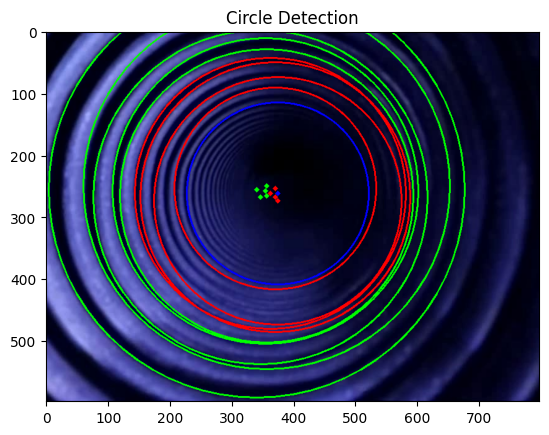

In [29]:
circles = cv2.HoughCircles(mean_ad, cv2.HOUGH_GRADIENT, 1, 6.8, param1=80, param2=40, minRadius=50, maxRadius=600)

if circles is not None:
    circles = np.uint16(np.around(circles))
    first_count = 0
    second_count = 0
    third_count = 0

    for i in circles[0, :]:
        print(i)
        if i[2] >= 220 and first_count < 5:
            # outer circle
            cv2.circle(pipe_pic, (i[0], i[1]), i[2], (0,255,0), 2)
            # center of circle
            cv2.circle(pipe_pic, (i[0], i[1]), 2, (0,255,0), 3)
            first_count += 1
        elif i[2] < 220 and i[2] > 150 and second_count < 4:
            # outer circle
            cv2.circle(pipe_pic, (i[0], i[1]), i[2], (255,0,0), 2)
            # center of circle
            cv2.circle(pipe_pic, (i[0], i[1]), 2, (255,0,0), 3)
            second_count += 1
        elif i[2] < 150 and third_count < 1:
            # outer circle
            cv2.circle(pipe_pic, (i[0], i[1]), i[2], (0,0,255), 2)
            # center of circle
            cv2.circle(pipe_pic, (i[0], i[1]), 2, (0,0,255), 3)
            third_count += 1
        elif first_count == 5 and second_count == 4 and third_count == 1:
            break

plt.imshow(pipe_pic)
plt.title('Circle Detection')
plt.show()

DIRECTION MODEL

LOAD DATA

In [30]:
data = tf.keras.utils.image_dataset_from_directory('image_dataset')

Found 180 files belonging to 3 classes.


In [31]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

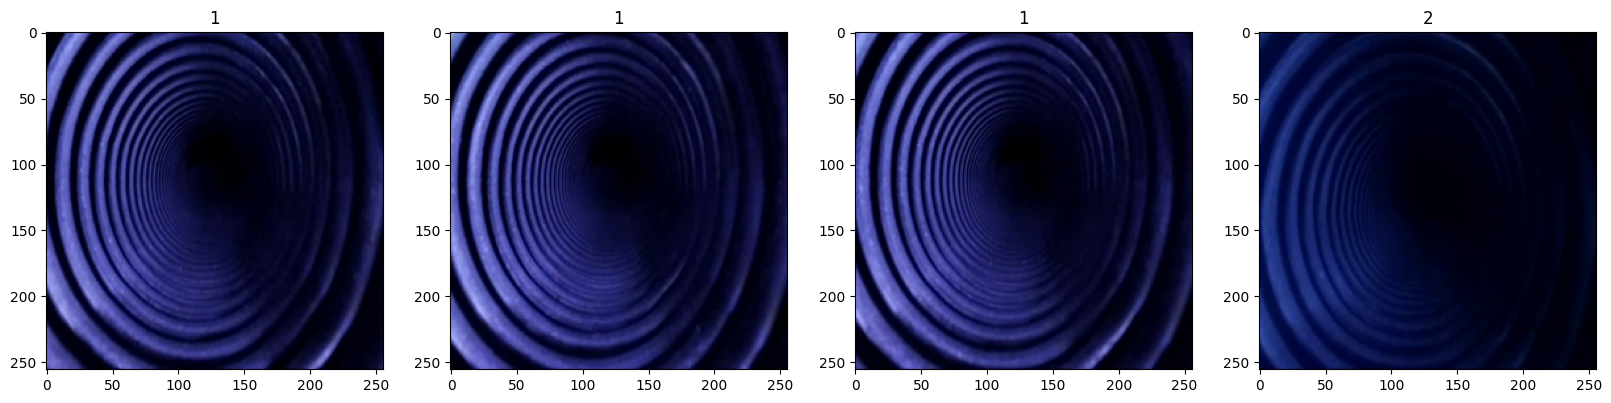

In [32]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

LEFT = Class 0

RIGHT = Class 1

STRAIGHT = Class 2

SCALE DATA

In [33]:
scaled_data = data.map(lambda x, y: (x/255, y))
size = len(scaled_data)
print(size)

6


TRAIN VALID TEST SIZE

In [34]:
train_size = int(size * 0.5)
valid_size = int(size * 0.4)
test_size = int(size * 0.1) + 1

print(train_size)
print(valid_size)
print(test_size)

train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(valid_size)
test = scaled_data.skip(train_size + valid_size).take(test_size)


3
2
1


In [35]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [36]:
model.compile('adam', loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)       

In [38]:
#callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss')
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


3/3 [==============================] - 1s 302ms/step - loss: 0.7048 - accuracy: 0.5729 - val_loss: 0.4509 - val_accuracy: 0.7031
Epoch 2/20
3/3 [==============================] - 1s 263ms/step - loss: 0.3679 - accuracy: 0.6562 - val_loss: 0.2380 - val_accuracy: 0.7031
Epoch 3/20
3/3 [==============================] - 1s 262ms/step - loss: 0.1383 - accuracy: 0.9167 - val_loss: 0.1105 - val_accuracy: 1.0000
Epoch 4/20
3/3 [==============================] - 1s 269ms/step - loss: 0.0603 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 1.0000
Epoch 5/20
3/3 [==============================] - 1s 263ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 6/20
3/3 [==============================] - 1s 262ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/20
3/3 [==============================] - 1s 277ms/step - loss: 7.1584e-04 - accuracy: 1.0000 - val_loss: 7.5378e-05 - val_accuracy: 1.0000
Epoch 8/20
3/3 [=======

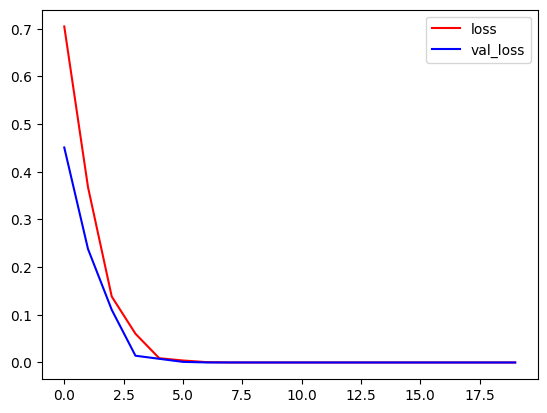

In [39]:
fig_loss = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
plt.legend(loc="upper right")
plt.show()

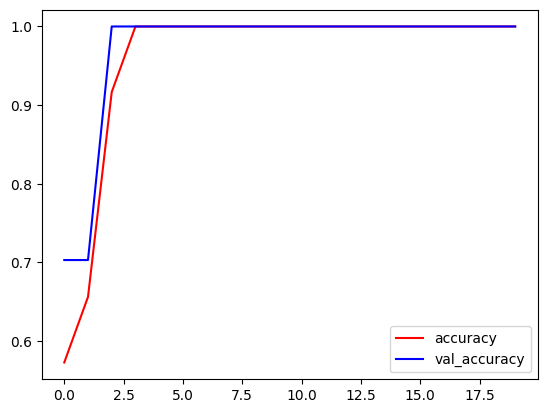

In [40]:
fig_acc = plt.figure()
plt.plot(hist.history['accuracy'], color='red', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
plt.legend(loc="lower right")
plt.show()